# Anomaly Detection: Simple Z-Score

In [ ]:
%pip install seaborn

## Sample Data 만들기  

In [41]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

np.random.seed(42)
start_time = datetime.now()
datetimes = [start_time + timedelta(minutes=i) for i in range(1000)]

temperature = np.random.normal(loc=25, scale=5, size=1000)  # Mean 25, Std Dev 5
humidity = np.random.normal(loc=50, scale=10, size=1000)    # Mean 50, Std Dev 10
pm25 = np.random.normal(loc=30, scale=15, size=1000)        # Mean 30, Std Dev 15
pm10 = np.random.normal(loc=40, scale=20, size=1000)        # Mean 40, Std Dev 20

num_anomalies = int(0.05 * 1000)
anomaly_indices = np.random.choice(range(1000), num_anomalies, replace=False)

temperature[anomaly_indices] += np.random.uniform(15, 25, num_anomalies)  # Large deviations
humidity[anomaly_indices] += np.random.uniform(-20, -10, num_anomalies)
pm25[anomaly_indices] += np.random.uniform(50, 100, num_anomalies)
pm10[anomaly_indices] += np.random.uniform(-50, -30, num_anomalies)

df = pd.DataFrame({
    'datetime': datetimes,
    'temperature': temperature,
    'humidity': humidity,
    'pm25': pm25,
    'pm10': pm10
})
df.head()

,datetime,temperature,humidity,pm25,pm10
0,2024-11-19 20:43:42.546508,27.483571,63.993554,19.872326,1.843849
1,2024-11-19 20:44:42.546508,24.308678,59.246337,27.832220,22.792300
2,2024-11-19 20:45:42.546508,28.238443,50.596304,18.113701,31.727889
3,2024-11-19 20:46:42.546508,32.615149,43.530632,25.380577,77.753753
4,2024-11-19 20:47:42.546508,23.829233,56.982233,1.595780,51.131062


In [42]:
df.shape

(1000, 5)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     1000 non-null   datetime64[ns]
 1   temperature  1000 non-null   float64       
 2   humidity     1000 non-null   float64       
 3   pm25         1000 non-null   float64       
 4   pm10         1000 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 39.2 KB


In [44]:
df.describe()

,datetime,temperature,humidity,pm25,pm10
count,1000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2024-11-20 05:03:12.546508288,26.110475,49.960375,33.857496,37.607543
min,2024-11-19 20:43:42.546508,11.515567,12.427393,-15.292682,-59.072387
25%,2024-11-20 00:53:27.546508032,21.970658,43.368205,20.893235,23.360370
50%,2024-11-20 05:03:12.546508032,25.469704,50.210326,30.847176,38.711272
75%,2024-11-20 09:12:57.546508032,28.846173,56.817208,41.356080,51.852444
max,2024-11-20 13:22:42.546508,58.561884,81.931076,155.646940,104.861859
std,NaN,6.634043,10.514653,22.269429,22.759912


## 시각화: Lineplot

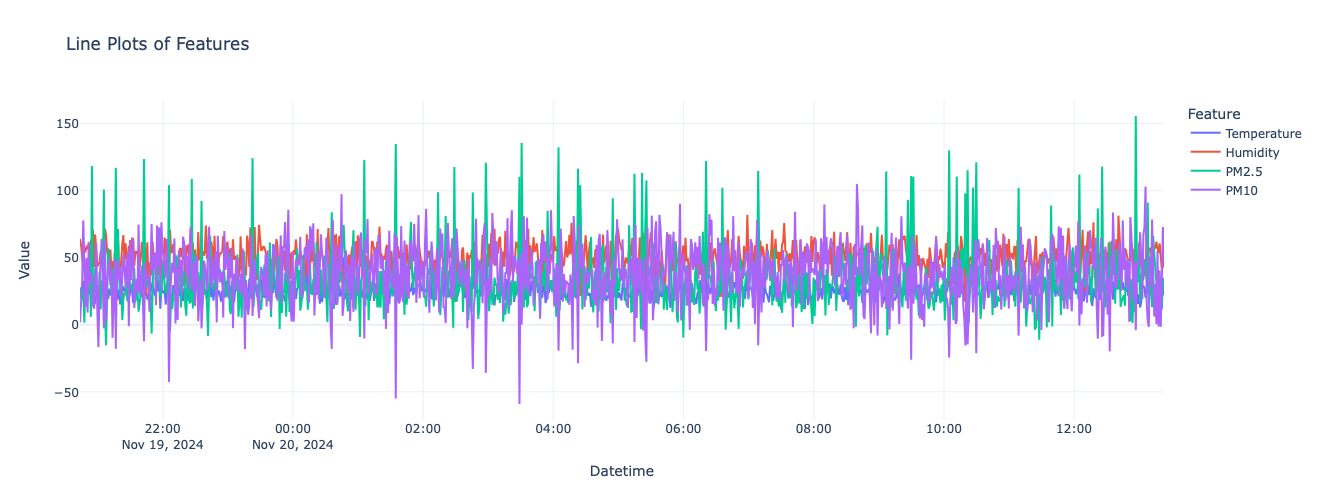

In [45]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

# temperature
fig.add_trace(go.Scatter(x=df['datetime'], y=df['temperature'], mode='lines', name='Temperature'))

# humidity
fig.add_trace(go.Scatter(x=df['datetime'], y=df['humidity'], mode='lines', name='Humidity'))

# pm25
fig.add_trace(go.Scatter(x=df['datetime'], y=df['pm25'], mode='lines', name='PM2.5'))

# pm10
fig.add_trace(go.Scatter(x=df['datetime'], y=df['pm10'], mode='lines', name='PM10'))

fig.update_layout(
    height=500,
    title="Line Plots of Features",
    xaxis_title="Datetime",
    yaxis_title="Value",
    legend_title="Feature",
    template="plotly_white"
)

fig.show()

## Normal/Anomaly 생성

In [46]:
# Prepare the dataset (drop datetime for numerical analysis)
df_features = df.drop(columns=['datetime'])

# Create labels: 1 for normal, -1 for anomalies (assuming anomalies are already injected)
true_labels = [1] * len(df_features)
num_anomalies = int(0.05 * len(df_features))
true_labels[-num_anomalies:] = [-1] * num_anomalies  # Label anomalies as -1

## Train/Test Split

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_features, 
    true_labels, 
    test_size=0.3, 
    random_state=42, 
    stratify=true_labels
)

# IsolatonForest

In [48]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_train)

y_pred = iso_forest.predict(X_test)

y_pred = [1 if y == 1 else -1 for y in y_pred]

In [49]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=-1)
recall = recall_score(y_test, y_pred, pos_label=-1)
f1 = f1_score(y_test, y_pred, pos_label=-1)

results = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

print(classification_report(y_test, y_pred, target_names=["Normal", "Anomaly"]))

              precision    recall  f1-score   support

      Normal       0.05      0.07      0.06        15
     Anomaly       0.95      0.93      0.94       285

    accuracy                           0.89       300
   macro avg       0.50      0.50      0.50       300
weighted avg       0.91      0.89      0.90       300



## Adjucsted Precison @n

In [50]:
def adjusted_precision_at_n(y_true, y_scores, n):
 
    sorted_indices = np.argsort(y_scores)[::-1]
    top_n_indices = sorted_indices[:n]
    
    top_n_true = np.array(y_true)[top_n_indices]
    precision_at_n = np.mean(top_n_true == -1)
    
    return precision_at_n

In [51]:
y_scores_iforest = iso_forest.decision_function(X_test)
n = 50 
precision_at_n = adjusted_precision_at_n(y_test, y_scores, n)

precision_result = {"Adjusted Precision @n": precision_at_n, "n": n}
print(precision_result)

{'Adjusted Precision @n': 0.04, 'n': 50}


## OneClassSVM, LOF

In [52]:
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor


one_class_svm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
one_class_svm.fit(X_train)

y_scores_svm = one_class_svm.decision_function(X_test)
precision_at_n_svm = adjusted_precision_at_n(y_test, y_scores_svm, n)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)
lof.fit(X_train)

y_scores_lof = lof.decision_function(X_test)
precision_at_n_lof = adjusted_precision_at_n(y_test, y_scores_lof, n)

results = {
    "Model": ["One-Class SVM", "Local Outlier Factor (LOF)"],
    "Adjusted Precision @n": [precision_at_n_svm, precision_at_n_lof],
    "n": [n, n]
}

pd.DataFrame(results)

/home/kubwa/anaconda3/envs/lecture/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but LocalOutlierFactor was fitted with feature names



,Model,Adjusted Precision @n,n
0,One-Class SVM,0.04,50
1,Local Outlier Factor (LOF),0.02,50


## 결과 시각화

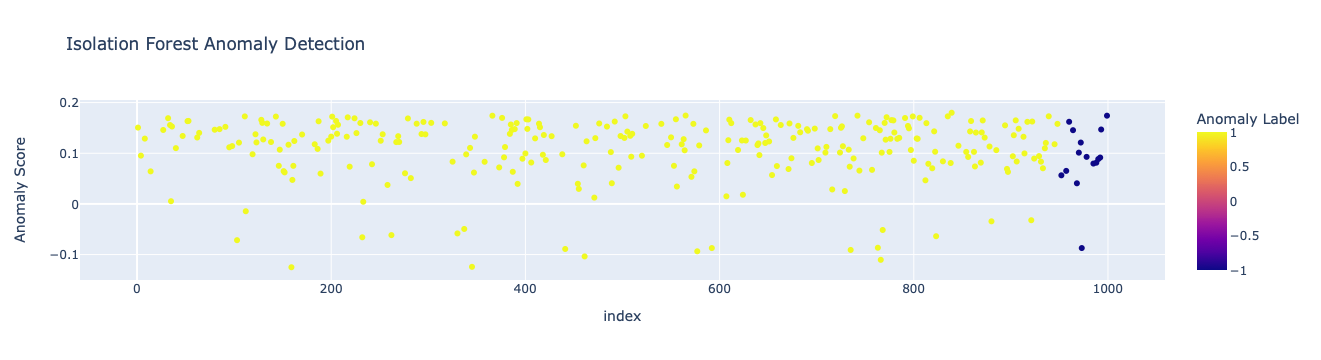

In [61]:
import plotly.express as px

fig_iforest = px.scatter(
    X_test,
    x=X_test.index,
    y='iForest',
    color='True_Label',
    title="Isolation Forest Anomaly Detection",
    labels={'True_Label': 'Anomaly Label', 'iForest': 'Anomaly Score'},
    color_discrete_map={1: 'blue', -1: 'red'},
    hover_data=['iForest']
)
fig_iforest.show()

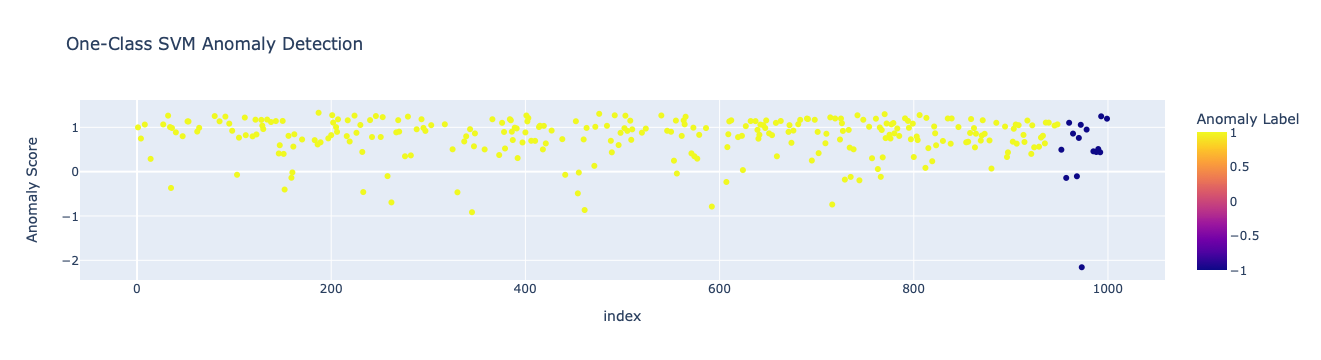

In [62]:
fig_svm = px.scatter(
    X_test,
    x=X_test.index,
    y='SVM_Score',
    color='True_Label',
    title="One-Class SVM Anomaly Detection",
    labels={'True_Label': 'Anomaly Label', 'SVM_Score': 'Anomaly Score'},
    color_discrete_map={1: 'blue', -1: 'red'},
    hover_data=['SVM_Score']
)
fig_svm.show()

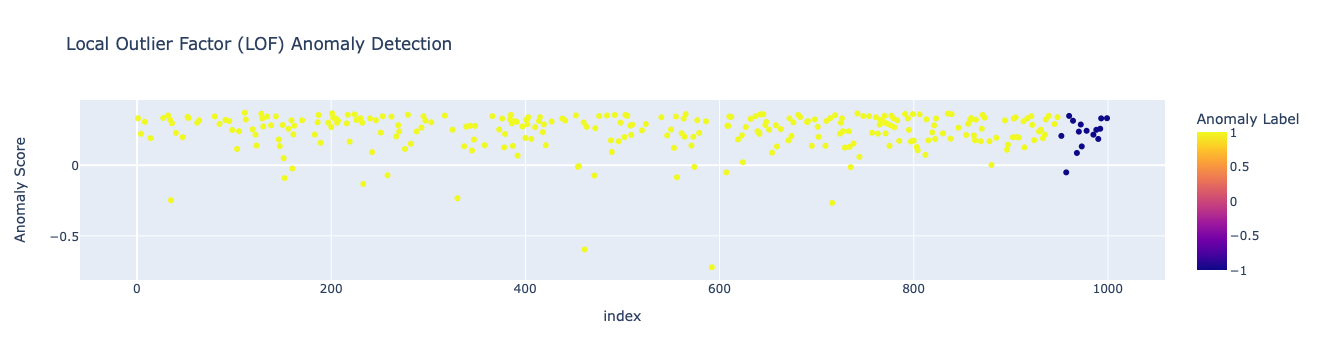

In [63]:
fig_lof = px.scatter(
    X_test,
    x=X_test.index,
    y='LOF_Score',
    color='True_Label',
    title="Local Outlier Factor (LOF) Anomaly Detection",
    labels={'True_Label': 'Anomaly Label', 'LOF_Score': 'Anomaly Score'},
    color_discrete_map={1: 'blue', -1: 'red'},
    hover_data=['LOF_Score']
)
fig_lof.show()